In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib

# Trend prediction

## Service functions

In [2]:
def generate_resource_load(max_idx, trend_type):
    lam = 1
    noise = 15*(np.random.poisson(lam, max_idx + 1) - lam)/np.sqrt(lam)
    time_idx = np.sort(np.random.choice(a=list(range(0, max_idx)), size=np.random.randint(max_idx//5, max_idx), replace=False))
    time_idx = np.append(time_idx, max_idx)
    if trend_type == 'linear':
        trend = 10 + time_idx*(70 - 10)/max_idx
    elif trend_type == 'const':
        trend = 30
    elif trend_type == 'exp':
        trend = 3 + np.exp(4*time_idx/max_idx)*(70 - 3)/np.exp(4*max_idx/max_idx)
    else:
        raise Exception(f"Unknown trend type: {trend_type}")
    out_signal = trend + noise[time_idx]
    out_signal = np.clip(out_signal, 0, 100)
    return time_idx, out_signal

In [3]:
def confidence_from_pdf(pdf_y):
    norm = pdf_y.sum()
    if norm > 1e-4:
        pdf_y /= norm
    else:
        return 0
    conf_thr = 1/len(pdf_y) + 0.1  # must be greater than 1/len(pdf_y) to avoid confidence in uniform distribution
    return np.count_nonzero(pdf_y >= conf_thr)/len(pdf_y)


def preprocess_data(res_times, res_vals, stat_window):
    win_pos = 0
    win_end = res_times.max() - stat_window
    out_times = []
    out_means = []
    out_probs = []
    out_pdfs = []
    while win_pos <= win_end:
        idx = np.argwhere((res_times >= win_pos) & (res_times < win_pos + stat_window))
        if len(idx) == 0:
            win_pos += stat_window
            continue
        times = res_times[idx]
        vals = res_vals[idx]

        out_times.append(win_pos + stat_window//2)
        out_means.append(vals.mean())

        PDF_BINS = 20
        PTS_COUNT = len(vals)
        if PTS_COUNT > 0:
            # https://en.wikipedia.org/wiki/Standard_error#Finite_population_correction_(FPC)
            MIN_SAMPLES_PER_BIN = 10  # 10% error per bin?
            DESIRED_SAMPLES = PDF_BINS*MIN_SAMPLES_PER_BIN
            if PTS_COUNT < DESIRED_SAMPLES:
                fpc = np.sqrt((DESIRED_SAMPLES - PTS_COUNT)/(DESIRED_SAMPLES - 1))
            else:
                fpc = 1

            pdf_win_pos = vals.min()
            vals_max = vals.max()
            pdf_win_len = (vals_max + 1e-4 - vals.min())/PDF_BINS
            pdf_high = []
            pdf_low = []
            while pdf_win_pos <= vals_max:
                k = np.count_nonzero((vals >= pdf_win_pos) & (vals < pdf_win_pos + pdf_win_len))
                if k == 0:
                    pdf_high.append(0)  # (1*fpc)
                    pdf_low.append(0)
                    pdf_win_pos += pdf_win_len

                # Here we suppose that histogram is optimal estimation of PDF (in sense of mean difference <||hist - PDF||>),
                # but actually I didn't find any good proofs
                p = k/PTS_COUNT
                moe = 1.96*np.sqrt(p*(1 - p)/PTS_COUNT)*fpc  # https://en.wikipedia.org/wiki/Margin_of_error

                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                binom_stats_high = scipy.stats.binomtest(k=k, n=PTS_COUNT, p=min(p + moe, 1 - 1e-4), alternative='two-sided')
                binom_stats_low = scipy.stats.binomtest(k=k, n=PTS_COUNT, p=max(p - moe, 1e-4), alternative='two-sided')
                ci_high = binom_stats_high.proportion_ci(confidence_level=0.95, method='exact')
                ci_low = binom_stats_low.proportion_ci(confidence_level=0.95, method='exact')
                pdf_high.append(max(ci_high.high, ci_low.high)/PDF_BINS)
                pdf_low.append(max(ci_high.low, ci_low.low)/PDF_BINS)

                pdf_win_pos += pdf_win_len
            pdf_high = np.array(pdf_high)
            pdf_low = np.array(pdf_low)
            window_confidence = min(confidence_from_pdf(pdf_high), confidence_from_pdf(pdf_low))  # let's take worst estimation
            out_probs.append(window_confidence)
            out_pdfs.append((np.arange(vals.min(), vals_max + pdf_win_len + 1e-4, pdf_win_len)[:len(pdf_high) + 1], (pdf_high + pdf_low)/2))
        else:
            out_probs.append(0)
            out_pdfs.append(None)

        win_pos += stat_window

    out_times = np.array(out_times)
    out_means = np.array(out_means)
    out_probs = np.array(out_probs)
    remove_mask = out_probs < 1e-4
    out_times = out_times[~remove_mask]
    out_means = out_means[~remove_mask]
    out_probs = out_probs[~remove_mask]
    remove_idxs = np.argwhere(remove_mask)
    out_pdfs = [elem for i, elem in enumerate(out_pdfs) if i not in remove_idxs]
    return out_times, out_means, out_probs, out_pdfs

In [4]:
def exp_func(x, a, b, c, d):
    return a * np.exp(b * x + d) + c


def predict_warning(times, pdfs, probs, warn_val):
    ERR_THR = 5  # absolute value
    MAX_PREDICT_HORIZON = 10  # (times.max() - times.min())*MAX_PREDICT_HORIZON

    min_err = np.inf
    min_warn_time = None
    min_warn_type = None
    min_forecast_times = None
    min_forecast_vals = None
    all_warn_times = []
    all_warn_types = []
    all_forecast_times = []
    all_forecast_vals = []
    for _ in range(100):
        vals = []
        for pdf_xs, pdf_ys in pdfs:
            norm = pdf_ys.sum()
            if norm > 0:
                normed_pdf = pdf_ys/norm
            else:
                normed_pdf = np.full(len(pdf_ys), 1/len(pdf_ys))
            vals.append(np.random.choice((pdf_xs[:-1] + pdf_xs[1:])/2, size=1, p=normed_pdf)[0])
        vals = np.array(vals)

        lin_err = np.inf
        if len(vals) > 1:
            lin_coeffs = np.polyfit(times, vals, 1, w=probs)
            lin_err = np.sqrt((lin_coeffs[1] + times*lin_coeffs[0] - vals)**2).mean()
    
        exp_err = np.inf
        if len(vals) > 4:
            try:
                popt, _ = scipy.optimize.curve_fit(exp_func, times, vals, p0=(1, 1/times.max(), 0, 0), sigma=1/probs)
                exp_err = np.sqrt((exp_func(times, *popt) - vals)**2).mean()
            except RuntimeError as e:
                print(f"Exponential fit exception: {e}")
                exp_err = np.inf
            if not np.isfinite(exp_err):
                exp_err = np.inf  # just in case, for NaN and -INF

        warn_time = None
        warn_type = None
        forecast_times = None
        forecast_vals = None

        # FIXME: the conditions below include extra normalizations, which can influence on statistics
        check_lin = lin_err < ERR_THR and abs(lin_coeffs[0]) > 1e-4 and lin_coeffs[0] > 0
        check_exp = exp_err < ERR_THR and abs(popt[0]) > 1e-4 and abs(popt[1]) > 1e-4 and popt[0]*popt[1] > 0
        if check_lin and check_exp:
            if lin_err <= exp_err:
                check_exp = False
            else:
                check_lin = False
        if check_lin:
            current_err = lin_err
            warn_time = (warn_val - lin_coeffs[1])/lin_coeffs[0]
            if warn_time < times.max() or warn_time > times.min() + MAX_PREDICT_HORIZON*(times.max() - times.min()):
                warn_time = None
            else:
                warn_type = 'linear'
                forecast_times = np.linspace(times.max(), warn_time, 10)
                forecast_vals = lin_coeffs[1] + lin_coeffs[0]*forecast_times
        if check_exp:
            current_err = exp_err
            warn_time = (np.log((warn_val - popt[2])/popt[0]) - popt[3])/popt[1]
            if warn_time < times.max() or warn_time > times.min() + MAX_PREDICT_HORIZON*(times.max() - times.min()):
                warn_time = None
            else:
                warn_type = 'exponential'
                forecast_times = np.linspace(times.max(), warn_time, 10)
                forecast_vals = popt[2] + popt[0]*np.exp(popt[1]*forecast_times + popt[3])

        if warn_time is not None:
            all_warn_times.append(warn_time)
            all_warn_types.append(warn_type)
            all_forecast_times.append(forecast_times)
            all_forecast_vals.append(forecast_vals)

        if warn_time is not None and current_err < min_err:
            min_warn_time = warn_time
            min_warn_type = warn_type
            min_forecast_times = forecast_times.copy()
            min_forecast_vals = forecast_vals.copy()

    return min_warn_time, min_warn_type, min_forecast_times, min_forecast_vals

In [5]:
def plot_case(res_times, res_vals, high_warn_level):
    default_figsize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (15, 7)

    fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=(5, 2))
    axs[0].plot(res_times, res_vals, '.-', c='gray', alpha=0.5)

    time_avg_step = (res_times.max() - res_times.min())/len(res_times)
    time_window_length = min(max((res_times.max() - res_times.min())/10, time_avg_step*50), time_avg_step*200)
    prep_times, prep_means, prep_probs, prep_pdfs = preprocess_data(res_times, res_vals, time_window_length)
    axs[0].plot(prep_times, prep_means, '--', c='blue')

    probs_norm = prep_probs.sum()
    if probs_norm > 1e-4:
        normed_prep_probs = prep_probs/probs_norm
    else:
        normed_prep_probs = np.zeros(len(prep_probs))
    dot_sizes = (100 - 5)*normed_prep_probs + 10
    axs[0].scatter(prep_times, prep_means, s=dot_sizes, c='blue', zorder=100)

    print(f"Estimated probabilities for windows: {prep_probs}")
    warn_time, warn_type, fore_times, fore_vals = predict_warning(prep_times[-10:], prep_pdfs[-10:], prep_probs[-10:], high_warn_level)
    if warn_time is not None:
        axs[0].axhline(high_warn_level, linestyle='--', c='red')
        axs[0].annotate(f"warning = {int(high_warn_level)}%", (res_times.min(), high_warn_level + 1))
        axs[0].plot(fore_times, fore_vals, linestyle='--', c='orange')
        fig.suptitle(f"Prediction: warning level at {warn_time:.2f}, growth: {warn_type}")
    else:
        fig.suptitle("Prediction: no growth to warning level")

    pdf_colormap = matplotlib.colormaps.get_cmap('Greys')
    axs[1].set_ylim(res_vals.min(), res_vals.max())
    for (pdf_xs, pdf_ys), pdf_time in zip(prep_pdfs, prep_times):
        for i in range(len(pdf_ys)):
            rect = matplotlib.patches.Rectangle(
                (pdf_time - time_window_length/2, pdf_xs[i]),
                time_window_length, pdf_xs[i + 1] - pdf_xs[i],
                linewidth=0,
                edgecolor='none',
                facecolor=pdf_colormap(int(256*pdf_ys[i]/pdf_ys.max())),
            )
            axs[1].add_patch(rect)

    plt.show()

    plt.rcParams['figure.figsize'] = default_figsize

## Plots on generated data

To check trends by regression we want to make as less as possible assumptions about the system. First of all, it looks like we can estimate only linear trend now, because e.g. for exponential trend it is very hard to distinguish it from linear one at the begiining of the trend, while at the end of the trend, threshold is usually reached sooner than warning comes. Secondly, we don't know noise in the system, and we want to make only very necessary assumptions about it.

The task is to get probability $P(t^{*})$ for $t^{*}$, which is prediction of the moment when resource usage reach warning level. If trend for research usage is described by a function $y=f(t)$ (which for discrete points is $y_{i}=f(t_{i}, \vec \lambda)$), we could define $P(t^{*})$ as $P(f^{-1}(y^{*}, \vec \lambda))$ where $y^{*}$ is warning level and $\vec \lambda$ is unknown parameters of $f(t)$. However this would not help much, because we measure noisy function, and we need to add noise to the system: one way is to describe noise as uncertainty in parameters $\vec \lambda$, and another way is to say that we measure $z_{i} = y_{i} + {\xi}_{i} = f(t_{i}, \vec \lambda) + {\xi}_{i}$ (postulate additive noise). The latter variant looks closer to reality, so let's take it.

In spite of our postulation of additive noise in the system, we don't want to make a lot of _a priori_ assumptions about it (i.e. set _a priori_ $P(\xi)$). Consequently, we can't use Bayes formulas to get $P(t^{*})$ directly, because they require analytical form for $P(\xi)$ (and most probably we would get the same problem with analytical form of $P(\vec \lambda)$ in the alternative variant of noise description).

Just for the record, although Bayes way is not directly suitable in this case, let's write down main formulas, which can be used to prove this:
1. $P(t^{*}) = P(g^{-1}(z^{*})) = \int_{\Lambda, \Theta}{P(g^{-1}(z^{*})|\vec \lambda, \vec \theta)) \cdot P(\vec \lambda) \cdot P(\vec \theta) d{\vec \lambda} d{\vec \theta}}$, where $z$ - measured resource level ($z^{*}$ - warning level), $\vec \theta$ - generalized measurement noise, $g(t, \vec \lambda, \vec \theta) = G(f(t, \vec \lambda), \vec \theta)$ - connection between trend and measurement noise, $f(t, \vec \lambda)$ - trend, $\vec \lambda$ - parameters of trend;
   1. For additive noise $\vec \theta = \xi$, $G(f(t, \vec \lambda), \vec \theta) = f(t, \vec \lambda) + \xi$, and $P(t^{*}) = P(f^{-1}(z^{*} - \xi)) = \int_{\Lambda, \Xi}{P(f^{-1}(z^{*} - \xi)|\vec \lambda, \xi)) \cdot P(\vec \lambda) \cdot P(\xi) d{\vec \lambda} d{\xi}}$, where $P(\vec \lambda)$ - _a priori_ distribution of parameters (can be even univariate, not a big problem), and $P(\xi)$ - analytical expression for noise probability (we don't have it).
   1. For noise in parameters $\vec \theta = \varnothing$, $G(f(t, \vec \lambda), \vec \theta) = f(t, \vec \lambda)$, and $P(t^{*}) = P(f^{-1}(z^{*})) = \int_{\Lambda}{P(f^{-1}(z^{*})|\vec \lambda)) \cdot P(\vec \lambda) d{\vec \lambda}}$, but now $\vec \lambda$ is random (noisy) variable, so $P(\vec \lambda)$ - its _a posteriori_ distribution in analytical form (we don't have it).
1. Bayes eqs for the approaches from the previous point:
   1. $P(y_1, y_2, ..., y_{n}|z_1, z_2, ..., z_{n}) = \frac{P(z_1, z_2, ..., z_{n}|y_1, y_2, ..., y_{n}) \cdot P(y_1, y_2, ..., y_{n})}{P(z_1, z_2, ..., z_{n})} = \frac{P(z_1, z_2, ..., z_{n}|\vec \lambda, {\xi}_1, {\xi}_2, ..., {\xi}_{n}) \cdot P(\vec \lambda) \cdot P({\xi}_1, {\xi}_2, ..., {\xi}_{n})}{P(z_1, z_2, ..., z_{n})}$
   1. $P(\vec \lambda|z_1, z_2, ..., z_{n}) = \frac{P(z_1, z_2, ..., z_{n}|\vec \lambda) \cdot P(\vec \lambda)}{P(z_1, z_2, ..., z_{n})}$
1. Trajectory probability when we have estimated ${\hat P}(z_{i})$ from the data (and assuming that ${\hat P}(z_{i}) = P(z_{i})$):
$P(z_1, z_2, ..., z_{n}|\vec \lambda, \vec \theta) = P(g(t_1, \vec \lambda, \vec \theta) = z_1) \cdot P(g(t_2, \vec \lambda, \vec \theta) = z_2) \cdot ... = \prod_{i=0}^{n}{P(g(t_{i}, \vec \lambda, \vec \theta) = z_{i})}$
1. We also can describe trend (trajectory), taking only previous $k=\dim{\vec \lambda}$ points: $P(z_{n})=\idotsint_{z_{n-1}, z_{n-2}, ..., z_{n-k}}{P(g(t_{n},\vec \lambda, \vec \theta)=z_{n}|z_{n-1}, z_{n-2}, ..., z_{n-k}) \cdot P(z_{n-1}, z_{n-2}, ..., z_{n-k})d{z_{n-1}}d{z_{n-2}} \dots d{z_{n-k}}}$. But since $P(z_{n-1}, ..., z_{n-k}) = \frac{P(z_{n-1}, ..., z_{n-k}|\vec \lambda, \vec \theta) \cdot P(\vec \lambda) \cdot P(\vec \theta)}{P(\vec \lambda, \vec \theta|z_{n-1}, ..., z_{n-k})}$ and $P(g(t_{n},\vec \lambda)=z_{n}|z_{n-1}, ..., z_{n-k}) = P(\vec \lambda, \vec \theta|z_{n-1}, ..., z_{n-k})P(\vec \lambda, \vec \theta|z_{n})$ (*latter may be not proved?!):
$P(z_{n})=\idotsint_{z_{n-1}, z_{n-2}, ..., z_{n-k}}{P(z_{n-1}, ..., z_{n-k}|\vec \lambda, \vec \theta)P(\vec \lambda)P(\vec \theta)P(\vec \lambda, \vec \theta|z_{n})d{z_{n-1}}d{z_{n-2}}\dots d{z_{n-k}}}$
There is nothing suitable for inference above, consequently.

We can get $P(t^{*})$ from the other ideas, through:
1. We believe that most probable trajectory in the noise (up to constant bias value) can be found by least squares condition. This means that noise is additive: $z_{i} = f(t_{i}, \vec \lambda) + {\xi}_{i}$. Actually, noise has mean at some constant $\bar \xi$, but we are OK to let it be $0$ from least squares method, and then account it in trend constant.
1. We don't want to account any uncertainty in parameters, so _a posteriori_ $P(\vec \lambda) = \delta(\vec \lambda - \vec {{\lambda}^{*}})$.
1. Since the whole signal is not stationary, let's process it in quasi-stationary windows to get "trend values" up to that noise constant.
1. We will approximate given values by some function with constant bias $f(t_{i}, \vec \lambda) = h(t_{i}, \vec \lambda) + c$, which after the least squares reconstruction will include trend bias and noise bias together ($c^{*} = {\hat c}^{*} + {\bar \xi}$). But this is not a problem for us, because when we predict reahing the threshold value, we need both biases together.
1. From the trend approximation, we can calculate _a posteriori_ noise distribution $P(\xi)$ (not symmetric function, because we didn't assume noise symmetry).
1. Assuming that noise is stationary at least at the interval $[t_{n}, t^{*}]$, we can infer  $P(t^{*})$ by "1-D sampling" from $P(\xi)$ and substituting it to $P(t_{*} = f^{-1}(z^{*} - \xi, \vec {{\lambda}^{*}}))=P(\xi)$.

In [6]:
GENERATED_DATA_PTS = 700

WARNING_VALUE = 90

Estimated probabilities for windows: []


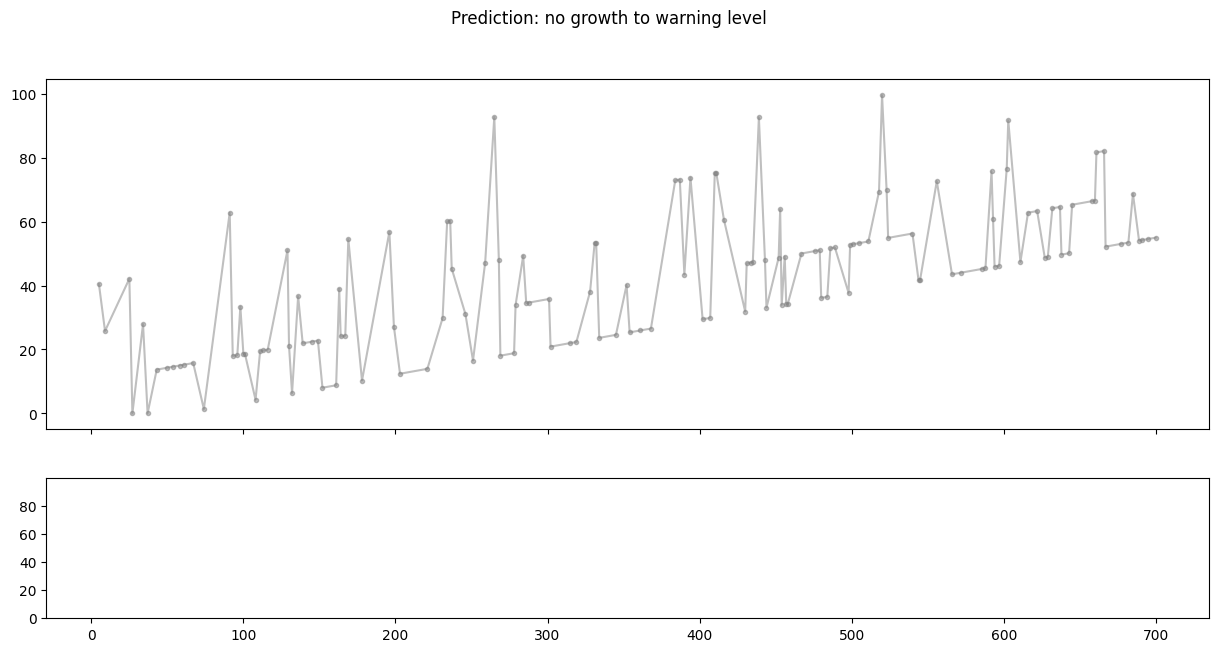

Estimated probabilities for windows: [0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal pa

/home/yakhno/eu_grants/smartdelta/smartdelta-ml-research/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev 

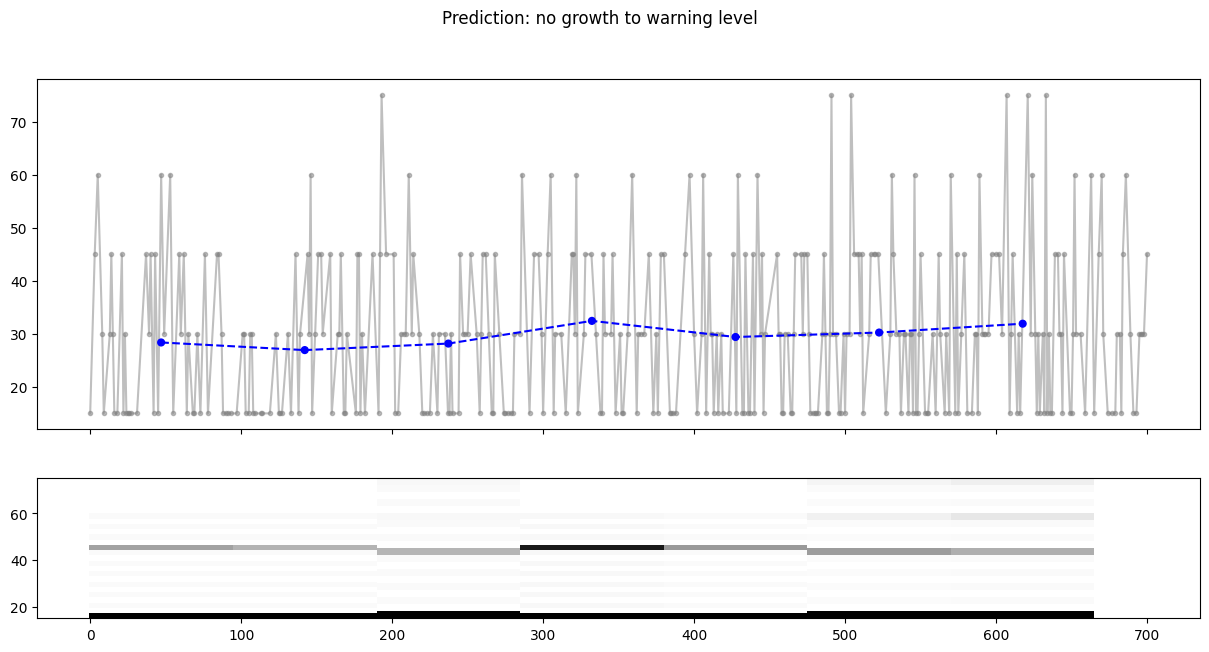

Estimated probabilities for windows: [0.1  0.1  0.05 0.1  0.1  0.1 ]
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal 

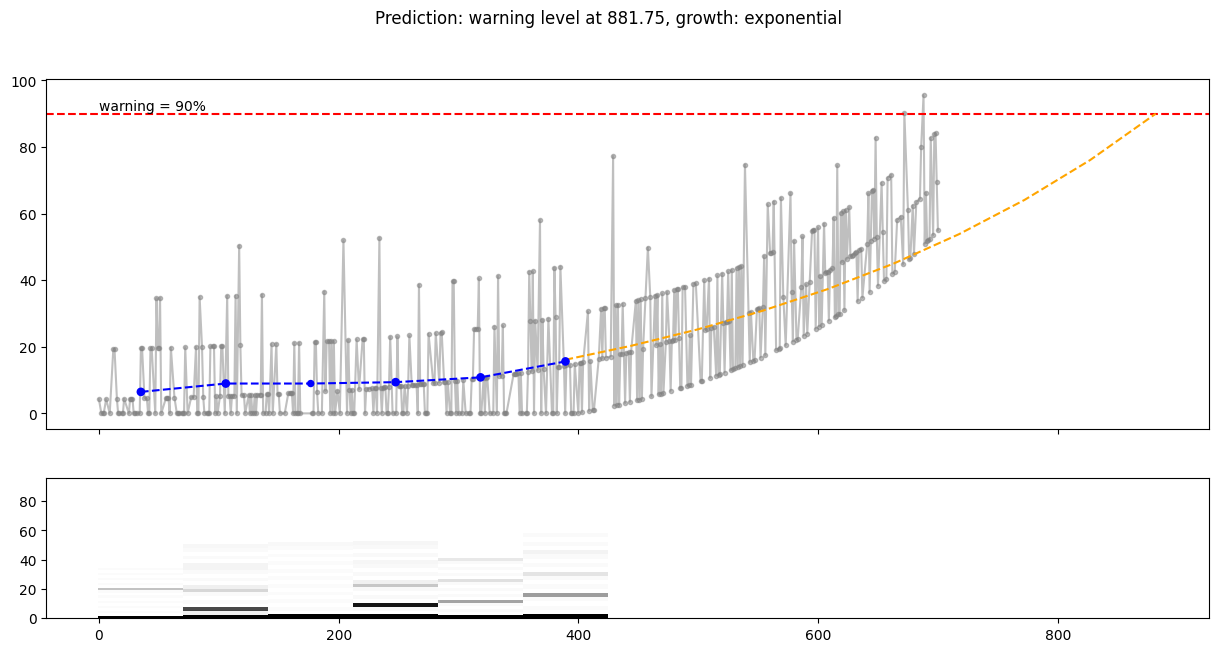

In [7]:
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'linear')
plot_case(res_times, res_vals, WARNING_VALUE)
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'const')
plot_case(res_times, res_vals, WARNING_VALUE)
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'exp')
plot_case(res_times, res_vals, WARNING_VALUE)

## Plots on real data

Data is taken from [this dataset](https://data.mendeley.com/datasets/rc6rwf7c8n/1).

In [8]:
res_df = pd.read_csv('data/resource_load_dataset/4802498578')

In [9]:
res_times = (res_df.iloc[:, 0] - res_df.iat[0, 0]).to_numpy()/1e7
assert len(np.unique(res_times)) == len(res_times)
res_vals = np.clip(res_df.iloc[:, 2].to_numpy()*100, 0, 100)
assert len(res_vals) == len(res_times)

remove_mask = ~(np.isfinite(res_times) & np.isfinite(res_vals))
res_times = res_times[~remove_mask]
res_vals = res_vals[~remove_mask]

print(f"Data length: {len(res_times)}")

Data length: 31089


Estimated probabilities for windows: [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.1  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.15 0.05 0.05 0.05
 0.05 0.1  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to fun

/home/yakhno/eu_grants/smartdelta/smartdelta-ml-research/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev 

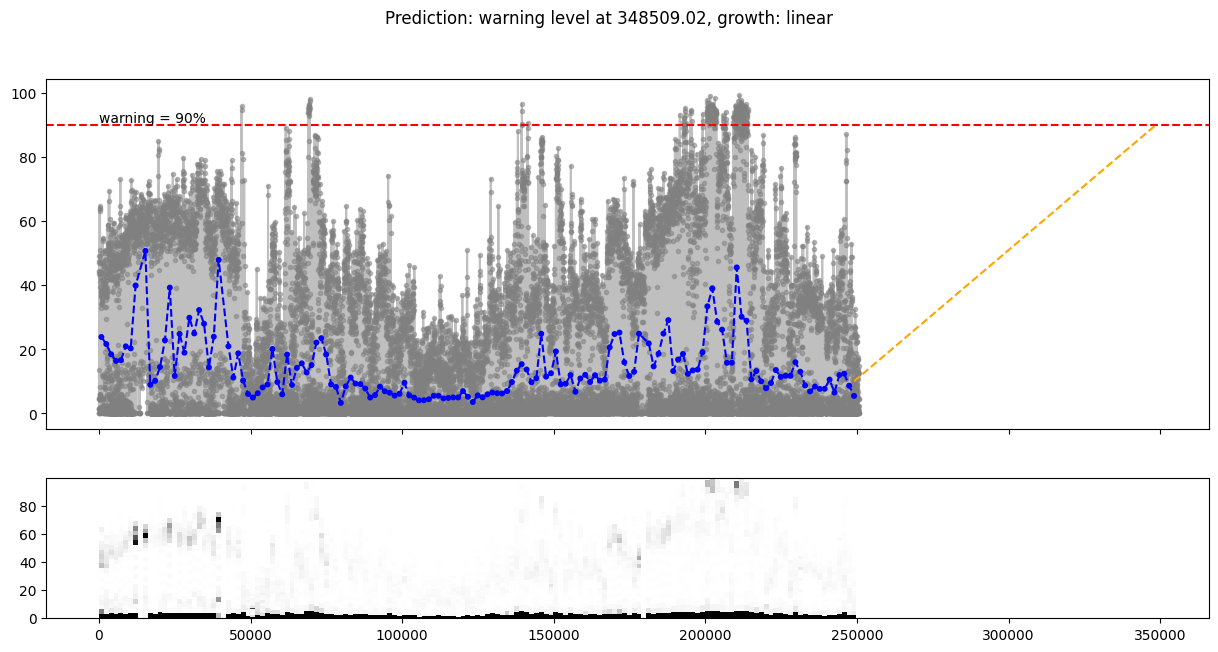

In [10]:
plot_case(res_times, res_vals, WARNING_VALUE)

Estimated probabilities for windows: [0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.05]
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Exponential fit exception

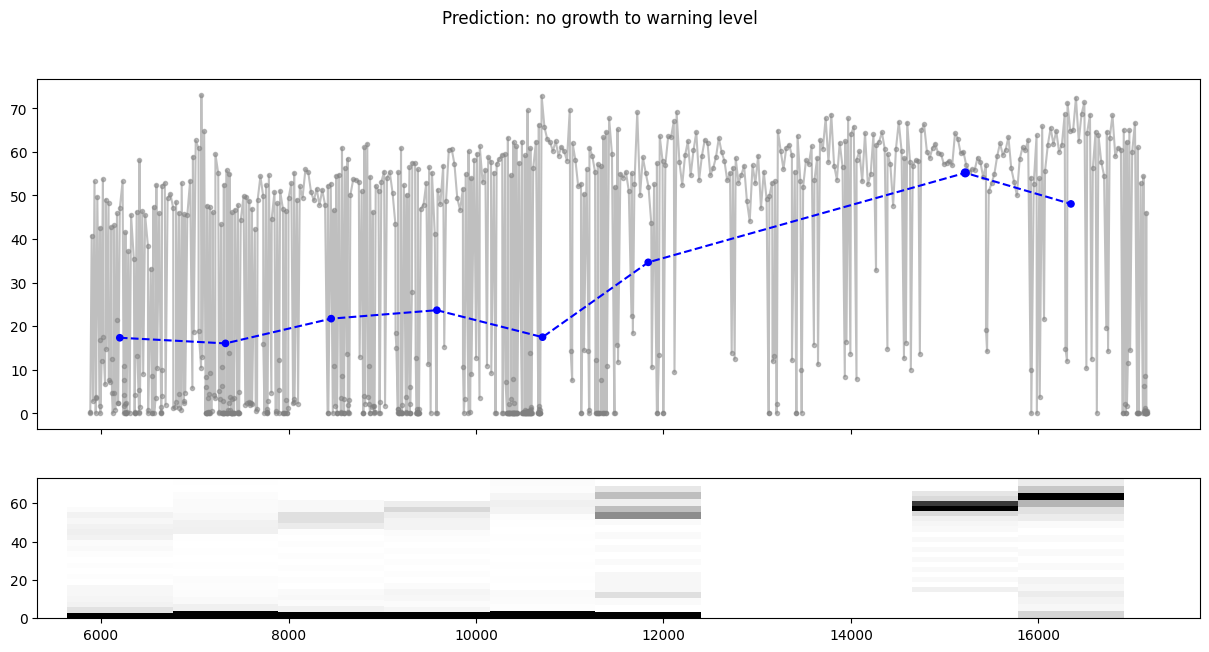

In [11]:
plot_case(res_times[500:1350], res_vals[500:1350], WARNING_VALUE)